In [1]:
%pylab inline 

%load_ext autoreload
%autoreload 2

from __future__ import division

import os
import copy
import argparse

import numpy as np
import scipy

# Astropy
from astropy.io import fits
from astropy.stats import sigma_clip
# AstroML
from astroML.plotting import hist

# Cubehelix color scheme from https://github.com/jradavenport/cubehelixscheme
import cubehelix
# For high-contrast image
cmap1 = cubehelix.cmap(start=0.5, rot=-0.8, gamma=1.0,
                       minSat=1.2, maxSat=1.2,
                       minLight=0.0, maxLight=1.0)
cmap1.set_bad('k', 1.)
# For Mask
cmap2 = cubehelix.cmap(start=2.0, rot=-1.0, gamma=2.5,
                       minSat=1.2, maxSat=1.2,
                       minLight=0.0, maxLight=1.0, reverse=True)
# For Sigma
cmap3 = cubehelix.cmap(start=0.5, rot=-0.8, gamma=1.2,
                       minSat=1.2, maxSat=1.2,
                       minLight=0.0, maxLight=1.0)

# Matplotlib related
import matplotlib.pyplot as plt
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 2.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 2.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 2.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 2.5

import sep

import hscUtils as hUtil

Populating the interactive namespace from numpy and matplotlib


In [2]:
def showSkyHist(skypix, skypix2=None, skypix3=None,
                sbExpt=None, pngName='skyhist.png', skyAvg=None, skyStd=None,
                skyMed=None, skySkw=None, savePng=True):
    """
    Plot the distribution of sky pixels.

    Parameters:
    """
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    fig.subplots_adjust(hspace=0.1, wspace=0.1,
                        top=0.95, right=0.95)
    fontsize = 18
    ax.minorticks_on()

    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)

    counts1, bins1, patches1 = hist(skypix, bins='knuth', ax=ax, alpha=0.4,
                                    color='cyan', histtype='stepfilled',
                                    normed=True)
    if skypix2 is not None:
        counts2, bins2, patches2 = hist(skypix2, bins='knuth', ax=ax,
                                        alpha=0.9, color='k', histtype='step',
                                        normed=True, linewidth=2)
    if skypix3 is not None:
        counts3, bins3, patches3 = hist(skypix3, bins='knuth', ax=ax,
                                        alpha=0.8, color='k', histtype='step',
                                        normed=True, linewidth=2,
                                        linestyle='dashed')
    # Horizontal line
    ax.axvline(0.0, linestyle='-', color='k', linewidth=1.5)

    # Basic properties of the sky pixels
    skyMin = np.nanmin(skypix)
    skyMax = np.nanmax(skypix)
    if skyAvg is None:
        skyAvg = np.nanmean(skypix)
    if skyStd is None:
        skyStd = np.nanstd(skypix)
    if skyMed is None:
        skyMed = np.nanmedian(skypix)
    if skySkw is None:
        skySkw = scipy.stats.skew(skypix)
    # Highligh the mode of sky pixel distribution
    ax.axvline(skyMed, linestyle='--', color='b', linewidth=1.5)

    ax.set_xlabel('Pixel Value', fontsize=20)
    ax.set_xlim(skyMed - 4.0 * skyStd, skyMed + 5.0 * skyStd)
    # Show a few information
    ax.text(0.7, 0.9, "Min : %8.4f" %
            skyMin, fontsize=21, transform=ax.transAxes)
    ax.text(0.7, 0.8, "Max : %8.4f" %
            skyMax, fontsize=21, transform=ax.transAxes)
    ax.text(0.7, 0.7, "Avg : %8.4f" %
            skyAvg, fontsize=21, transform=ax.transAxes)
    ax.text(0.7, 0.6, "Std : %8.4f" %
            skyStd, fontsize=21, transform=ax.transAxes)
    ax.text(0.7, 0.5, "Med : %8.4f" %
            skyMed, fontsize=21, transform=ax.transAxes)
    ax.text(0.7, 0.4, "Skew: %8.4f" %
            skySkw, fontsize=21, transform=ax.transAxes)
    if sbExpt is not None:
        ax.text(0.7, 0.3, "S.B : %8.5f" %
                sbExpt, fontsize=21, transform=ax.transAxes)

In [3]:
galId = '127'
sample = 'redBCG'

loc = os.path.join('/Users/songhuang/work/hscs/hsc_cutout/test', 
                   galId, 'HSC-I')
imgFile = sample + '_' + galId + '_HSC-I_full_img.fits'
mskFile = 'default/' + sample + '_' + galId + '_HSC-I_full_mskall.fits'

imgData = fits.open(os.path.join(loc, imgFile))[0].data
mskData = fits.open(os.path.join(loc, mskFile))[0].data

In [4]:
imgData = imgData.byteswap().newbyteorder()

imgMasked = copy.deepcopy(imgData)
imgMasked[mskData > 0] = np.nan 

Image IMIN, IMAX: -0.05530,  0.06853
Image Min, Max: -0.31624,  0.27634


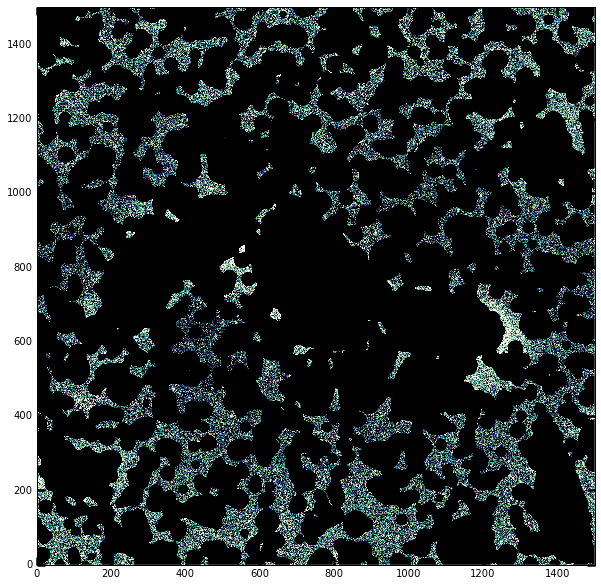

In [5]:
imin, imax = hUtil.zscale(imgData, contrast=0.75, samples=500)
print("Image IMIN, IMAX: %8.5f, %8.5f" % (imin, imax))
print("Image Min, Max: %8.5f, %8.5f" % (np.nanmin(imgMasked), 
                                        np.nanmax(imgMasked)))

plt.imshow(np.arcsinh(imgMasked), cmap=cmap1, interpolation="none",
           vmin=imin, vmax=imax, origin='lower')

-0.0172674246132 0.0476183593273
Surface brightness limit: 26.43211
BKG IMIN, IMAX : -0.04849,  0.01439
BKG: MIN, MAX : -0.04267,  0.06495


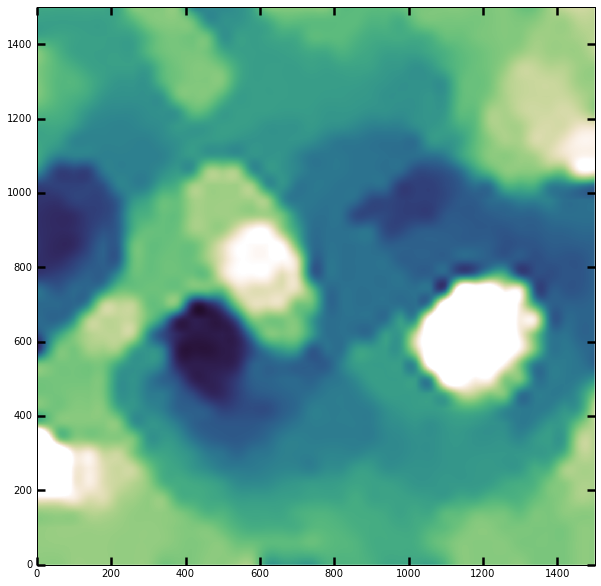

In [28]:
bkgSize = 40
bkgFilter = 5

bkg = sep.Background(imgData, mask=mskData, bw=bkgSize, bh=bkgSize, 
                     fw=bkgFilter, fh=bkgFilter)
imgBkg = bkg.back()

print bkg.globalback, bkg.globalrms
print("Surface brightness limit: %8.5f" % (-2.5 * np.log10(bkg.globalrms / (0.168 ** 2.0)) + 27.0))

imin, imax = hUtil.zscale(imgBkg, contrast=0.25, samples=500)
print("BKG IMIN, IMAX : %8.5f, %8.5f" % (imin, imax))
print("BKG: MIN, MAX : %8.5f, %8.5f" % (np.nanmin(imgBkg), 
                                        np.nanmax(imgBkg)))

plt.imshow(np.arcsinh(imgBkg), cmap=cmap1, interpolation="none",
           vmin=imin, vmax=imax, origin='lower')

In [19]:
sep.sum_circle(imgBkg, 700, 700, 200)

(array(-1682.5120954277452), array(0.0), array(0, dtype=int16))

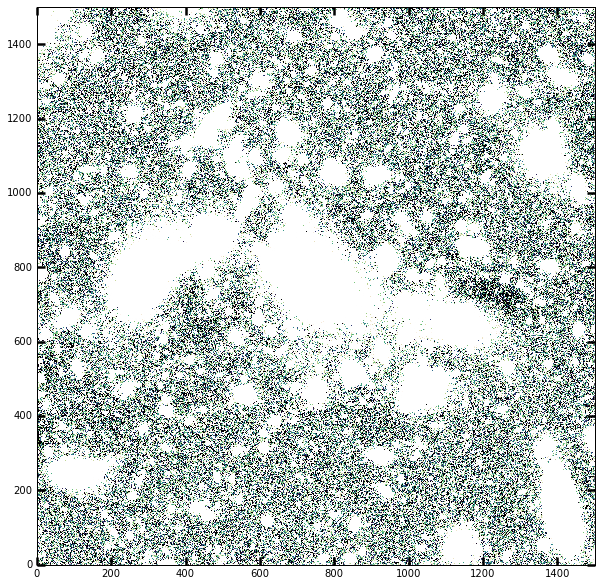

In [20]:
plt.imshow(np.arcsinh(imgData - imgBkg), cmap=cmap1, interpolation="none",
           vmin=imin, vmax=imax, origin='lower')

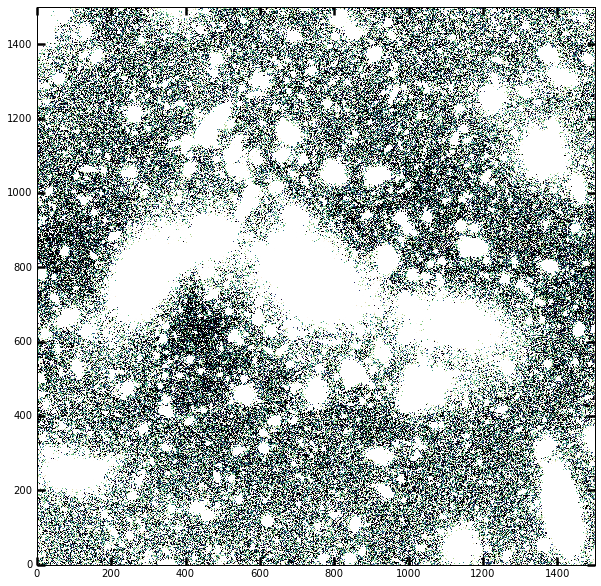

In [21]:
plt.imshow(np.arcsinh(imgData), cmap=cmap1, interpolation="none",
           vmin=imin, vmax=imax, origin='lower')

# Histogram of Sky Pixels

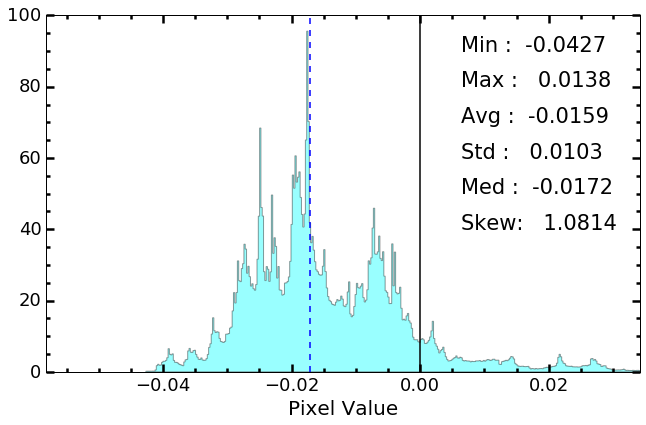

In [22]:
pixSky = imgBkg.flatten()
pixSkyClip = sigma_clip(pixSky, sigma=3.0, iters=3)

showSkyHist(pixSkyClip, savePng=False)

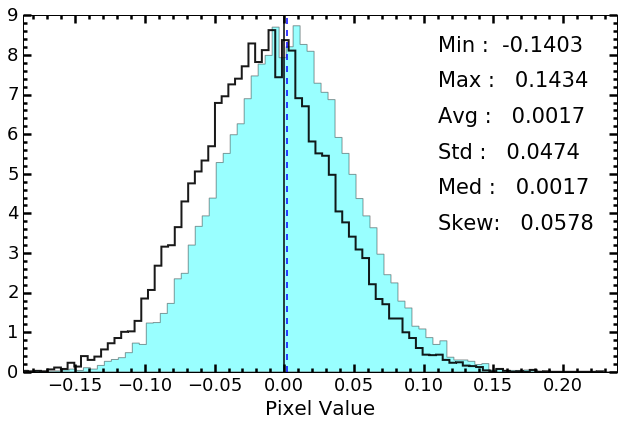

In [23]:
dimX, dimY = imgData.shape
rebin = 6

dimBinX = int((dimX - 1) / rebin)
dimBinY = int((dimY - 1) / rebin)

imgBin = hUtil.congrid(imgData, (dimBinX, dimBinY), method='nearest')
subBin = hUtil.congrid((imgData - imgBkg), (dimBinX, dimBinY), method='nearest')
mskBin = hUtil.congrid(mskData, (dimBinX, dimBinY), method='neighbour')

dimSkyX = int((dimX - 1) / (rebin * 4.0))
dimSkyY = int((dimY - 1) / (rebin * 4.0))
skyBin = hUtil.congrid(imgBkg, (dimSkyX, dimSkyY), method='neighbour')

pix1 = imgBin[mskBin == 0].flatten()
pix1a = sigma_clip(pix1, sigma=3.0, iters=3)

pix2 = subBin[mskBin == 0].flatten()
pix2a = sigma_clip(pix2, sigma=3.0, iters=3)

pix3 = skyBin.flatten()
pix3a = sigma_clip(pix3, sigma=3.0, iters=3)

showSkyHist(pix2a, savePng=False, skypix2=pix1a)